# Setup

 Import standard modules

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
import pandas as pd
import time
os.chdir('/home/chris/projects/tidal_flat_0d')

In [2]:
from src import features, models
from pyprojroot import here
root = here()
sys.path.append(str(root))
wdir = root / "data" / "interim"

Import project modules from src folder

In [3]:
tides = features.load_tide(wdir, "tides.feather")
tides = tides - (np.mean(tides) + 0.6)
# tides = tides.iloc[:int(len(tides) * 0.35)]

In [813]:
from src import models
import cProfile

sim = models.Simulation(
    tide_ts=tides,
    land_elev_init=1.15,
    conc_init=0.0,
    conc_bound=1.0,
    grain_diam=3.5e-5,
    grain_dens=2.65e3,
    bulk_dens=900,
    org_rate=2e-4,
    comp_rate=-4e-3,
    sub_rate=-3e-3,
    slr=0.005,
    solver_method="DOP853",
    years=2,
    min_depth=0.0,
    dense_output=True,
)
sim.simulate()

Progress: 100%|██████████| 351.0/351.0 [04:35<00:00,  1.27inundation/s]

----------------------------------------
Starting elevation:        1.150      m
Final elevation:           1.203      m
Elevation change:          5.284     cm
----------------------------------------
Aggradation:               6.587     cm
Degradation:              1.246      cm
----------------------------------------
Runtime:                      00:04:35


In [801]:
offset = sim.tides.index[-1] + sim.params.timestep
tide_ts = pd.Series(
        data=sim.tides.tide_elev + sim.params.slr,
        index=sim.tides.index + offset,
    )
x = models.Tides(
        tide_ts=tide_ts,
        land_elev_init=sim.results.df.land_elev.iat[-1],
        params=sim.params,
    )

In [809]:
sim.results.deg_total

0.012464622742247232

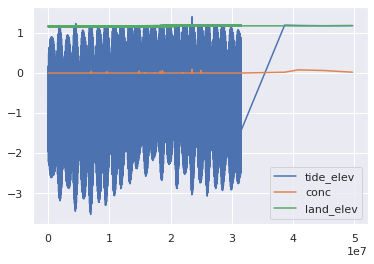

In [814]:
sim.results.plot(frac=0.001)